# First IREI Assignment: Profile-Based Retrieval
Author: David Cabornero Pascual

Preparation for libraries and data:

In [ ]:
# Only for installations
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install nltk
!pip install sklearn

In [32]:
# Creting folder data. If it already exists, it will return an error, but the result will be the same.
!mkdir "./data"

# Downloading dataset
!python3 -m wget 'http://disi.unitn.it/moschitti/corpora/ohsumed-first-20000-docs.tar.gz' -o './data'
!tar -xf "./data/ohsumed-first-20000-docs.tar.gz" -C "./data"
!mv "./data/ohsumed-first-20000-docs" "./data/ohsumed"
!rm "./data/ohsumed-first-20000-docs.tar.gz"

# Downloading control dataset
!python3 -m wget 'http://disi.unitn.it/moschitti/corpora/Reuters21578-Apte-90Cat.tar.gz' -o './data'
!tar -xf "./data/Reuters21578-Apte-90Cat.tar.gz" -C "./data"
!mv "./data/Reuters21578-Apte-90Cat" "./data/reuters"
!rm "./data/Reuters21578-Apte-90Cat.tar.gz"

# DISCLAIMER: if you are trying to download it when you already have it, it will work with the original version and you will recieve an
# error

100% [....................................................] 10208986 / 10208986
Saved under ./data/ohsumed-first-20000-docs.tar.gz
100% [......................................................] 5783726 / 5783726
Saved under ./data/Reuters21578-Apte-90Cat.tar.gz


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string as st
import re
from random import sample


from os import listdir
from os.path import isfile, join
import wget

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from nltk import PorterStemmer, WordNetLemmatizer
import nltk

nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/dcabornero/nltk_data...
[nltk_data]    |   Package movie_

True

# Reading dataset
* Selection of balanced classes
* Creation of the dataframe
* Creation of the control dataset

In [4]:
# random state of the whole notebook
rnd = 1000

In [5]:
# Selection of classes
mypath = "data/ohsumed/training"
folders = [join(mypath, f) for f in listdir(mypath)]

for fol in folders:
    files = [join(fol, f) for f in listdir(fol) if isfile(join(fol, f))]
    count = 0
    for i,name in enumerate(files):
        count += 1
    print("Class", fol.split('/')[-1],':',count)
    
chosen_classes = ['C06','C08','C10','C12','C20','C21']

Class C13 : 281
Class C10 : 621
Class C15 : 215
Class C06 : 588
Class C16 : 200
Class C12 : 491
Class C22 : 92
Class C05 : 283
Class C14 : 1249
Class C01 : 423
Class C07 : 100
Class C17 : 295
Class C23 : 1799
Class C08 : 473
Class C19 : 191
Class C18 : 388
Class C20 : 525
Class C04 : 1163
Class C03 : 65
Class C11 : 162
Class C02 : 158
Class C21 : 546
Class C09 : 125


In [6]:
# Creation of the dataframe
dataset_list = []
class_list = []

for clase in chosen_classes:
    fol = join(mypath,clase)
    files = [join(fol, f) for f in listdir(fol) if isfile(join(fol, f))]
    for name in files:
        with open(name,'r',encoding = "ISO-8859-1") as file:
            content = file.read()
            dataset_list.append(content)
            class_list.append(clase)
            
df = pd.DataFrame({"text":dataset_list, "category":class_list})

In [7]:
# Creation of the control dataframe
dataset_list = []

fol = 'data/reuters/training/dlr'
files = [join(fol, f) for f in listdir(fol) if isfile(join(fol, f))]
for name in files:
    with open(name,'r',encoding = "ISO-8859-1") as file:
        content = file.read()
        dataset_list.append(content)
            
df_control = pd.DataFrame({"text":dataset_list, "category":['None']*len(dataset_list)})

In [8]:
print(len(df),len(df_control))

3244 131


# Preprocessing of data
* Removal of worthless words and lemmatization
* Train/test division
* Addition of a balance control group to the test set with name "None"
* tf-idf trasformation

In [9]:
def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

def remove_small_words(text):
    return [x for x in text if len(x) > 4 ]

def remove_stopwords(text):
    # stopwords = [x for x in nltk.corpus.stopwords.words('english') if x not in forbidden]
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

def return_sentences(tokens):
    return " ".join([word for word in tokens])

def preprocess_element(text):
    return return_sentences(lemmatize(remove_stopwords(remove_small_words(tokenize(remove_punct(text))))))

In [10]:
df['text'] = df['text'].apply(lambda x: preprocess_element(x))
df_control['text'] = df_control['text'].apply(lambda x: preprocess_element(x))

X_train, X_test, y_train, y_test = train_test_split(df['text'],df['category'],train_size=0.7, random_state=rnd)
X_test = pd.concat([X_test,df_control['text']])
y_test = pd.concat([y_test,df_control['category']])

classes = np.unique(y_train)

In [11]:
tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(X_train.to_numpy()).todense()
tfidf_test = tfidf.transform(X_test.to_numpy()).todense()


# sim = cosine_similarity(tfidf_vect)


In [12]:
print(np.shape(tfidf_train))

(2270, 16233)


# Classification algorithms

### kNN

In [13]:
knn = KNeighborsClassifier(n_neighbors=15, metric = lambda x,y: 1-np.dot(x,y), weights=lambda x: 1-x)

knn.fit(np.asarray(tfidf_train),np.asarray(y_train))
preds = knn.predict(np.asarray(tfidf_test))


In [14]:
knn_probs = knn.predict_proba(np.asarray(tfidf_test))
knn_preds = knn.predict(np.asarray(tfidf_test))

### Neural Network

In [15]:
nn = MLPClassifier([256,128,64], early_stopping=True, n_iter_no_change=20, learning_rate='adaptive', random_state=rnd)
nn.fit(np.asarray(tfidf_train),np.asarray(y_train))

MLPClassifier(early_stopping=True, hidden_layer_sizes=[256, 128, 64],
              learning_rate='adaptive', n_iter_no_change=20, random_state=1000)

In [16]:
nn_probs = nn.predict_proba(np.asarray(tfidf_test))
nn_preds = nn.predict(np.asarray(tfidf_test))

# ROC and Precision-Recall Curves
Calculation of both curves for each algorithm. After that, the best threshold is calculated and indicated in a new chart in the ROC curves.

### ROC curves

In [17]:
# Converts the test predictions into binary ones
def convert_classes(y_test):
    y_real = []
    for pred in y_test:
        if pred == "None":
            y_real.append(0)
        else:
            y_real.append(1)
    return y_real

# Apart from plotting the correponding ROC curve, it returns the best threshold
def plot_one_roc(y_real,probs,name, plot_best):
    fpr, tpr, thresholds = roc_curve(y_real, [np.max(row) for row in probs])
    roc_auc = auc(fpr, tpr)
    
    lw = 2
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=name + " ROC curve (area = %0.3f)" % roc_auc,
    )
    # Calculation of best threshold
    argmax = np.argmax(tpr*(1-fpr))
    threshold = thresholds[argmax]
    print("Best threshold in "+name+": "+str(threshold))
    print("Best TPR in "+name+": "+str(tpr[argmax]))
    print("Best FPR in "+name+": "+str(fpr[argmax]))
    print()
    
    if plot_best:
        plt.plot(fpr[argmax], tpr[argmax], color='red', marker="x", markersize=10)
    
    return threshold

# Plot both ROC curves: knn and neural network
def plot_roc_curves(y_test, knn_probs, nn_probs, plot_best=False):
    best_thres = {}
    plt.figure()
    
    lw = 2
    y_real = convert_classes(y_test)
    
    best_thres['knn'] = plot_one_roc(y_real,knn_probs,"kNN", plot_best)
    best_thres['nn'] = plot_one_roc(y_real,nn_probs,"Neural Net", plot_best)
    
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.show()
    
    return best_thres

Best threshold in kNN: 0.45681264933539256
Best TPR in kNN: 0.6817248459958932
Best FPR in kNN: 0.22137404580152673

Best threshold in Neural Net: 0.8345786698074041
Best TPR in Neural Net: 0.6139630390143738
Best FPR in Neural Net: 0.03816793893129771



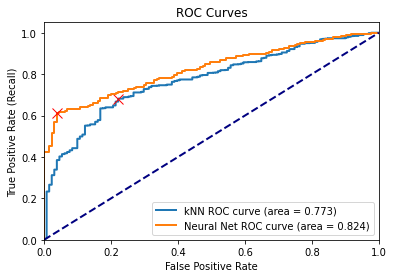

In [18]:
best_thres = plot_roc_curves(y_test, knn_probs, nn_probs, plot_best=True)

### Precision-Recall curves

In [19]:
def plot_one_recprec(y_real,probs,name):
    precision, recall, thresholds = precision_recall_curve(y_real, [np.max(row) for row in probs])
    # Precision empieza en 1 en vez de en 0
    lw = 2
    plt.plot(
        recall,
        precision,
        # color="darkorange",
        lw=lw,
        label=name,
    )

# Plot both Precision-Recall curves: knn and neural network
def plot_recprec_curves(y_test, knn_probs, nn_probs):
    plt.figure()
    
    lw=2
    y_real = convert_classes(y_test)
    
    plot_one_recprec(y_real,knn_probs,"kNN")
    plot_one_recprec(y_real,nn_probs,"Neural Net")

    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend(loc="lower left")
    plt.show()


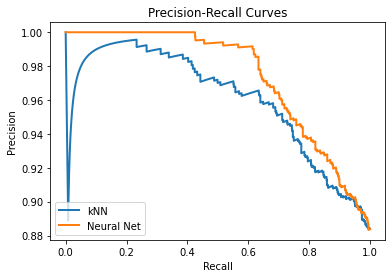

In [20]:
plot_recprec_curves(y_test, knn_probs, nn_probs)

# Another metrics:
* Selection of threshold for each algorithm
* Charts with confusion matrices and their difference
* Calculation of the rest of metrics:
    - Accuracy
    - Precision
    - Recall
    - F1-score

In [21]:
# The prediction remains only if the probability is higher than the threshold
def apply_threshold(preds, probs, threshold):
    new_preds = []
    maxprob = np.array([np.max(row) for row in probs])
    for pred,prob in zip(preds,maxprob):
        if prob < threshold:
            new_preds.append("None")
        else:
            new_preds.append(pred)
    return new_preds
    
knn_preds = apply_threshold(knn_preds,knn_probs, best_thres['knn'])

In [22]:
nn_preds2 = apply_threshold(nn_preds, nn_probs, best_thres['nn'])

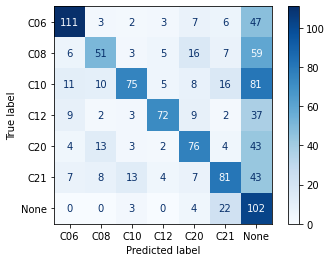

In [23]:
# Confusion Matrix in kNN
disp_knn = ConfusionMatrixDisplay.from_predictions(
        y_test,
        knn_preds,
        cmap=plt.cm.Blues,
    )

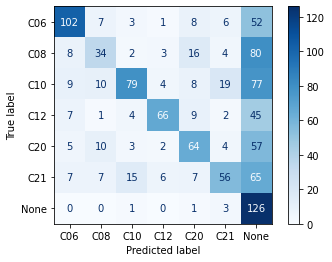

In [24]:
# Confusion matrix in the Neural Network
disp_nn = ConfusionMatrixDisplay.from_predictions(
        y_test,
        nn_preds2,
        cmap=plt.cm.Blues,
    )

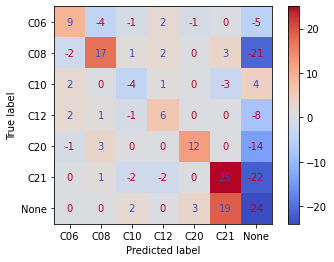

In [25]:
# Difference between knn and nn
ConfusionMatrixDisplay(disp_knn.confusion_matrix - disp_nn.confusion_matrix,
                      display_labels=disp_knn.display_labels).plot(
    cmap=plt.cm.coolwarm
    )

In [26]:
# Summary of the rest of metrics
def summary(y_pred, y_test):
    print("Accuracy:",str(accuracy_score(y_test,y_pred)))
    print("Precision:",str(precision_score(y_test,y_pred,average='macro',zero_division=1)))
    print("Recall:",str(recall_score(y_test,y_pred,average='macro',zero_division=1)))
    print("F1-score:",str(f1_score(y_test,y_pred,average='macro',zero_division=1)))
print("knn")
summary(y_test,knn_preds)
print("nn")
summary(y_test,nn_preds)

knn
Accuracy: 0.5140271493212669
Precision: 0.5240197158089845
Recall: 0.6136663342187256
F1-score: 0.5306470889560352
nn
Accuracy: 0.5592760180995475
Precision: 0.5432899786574078
Recall: 0.6348409727213836
F1-score: 0.5105185101779603


# Simulation of recommendations

In [27]:
# Users have to specify which kind of documents are relevant to them
dict_users = {1:['C06','C21','C12'],
             2:['C20'],
             3:['C21','C20'],
             4:['C08','C10'],
             5:['C12']}

In [28]:
def recommend_text(algorithm, dict_users, snippet):
    vector = tfidf.transform([preprocess_element(snippet)]).todense()
    prediction = algorithm.predict(np.array(vector))[0]
    print("Class of the text:", prediction)
    for user in dict_users.keys():
        if prediction in dict_users[user]:
            print('Sent to user', user)

In [29]:
recommend_text(nn, dict_users, X_test.iloc[150])

Class of the text: C10
Sent to user 4
